In [10]:
import nibabel as nib
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import rotate,shift,zoom,affine_transform
from scipy.signal import convolve2d
from scipy.interpolate import griddata

In [11]:
# MILESTONE 1: Loading images
nibimgs = []
nibhdrs = []
filenames = []
for file,subdir,d in os.walk(os.getcwd()):
    if 'analyze' in file:
        filenames.append(file)
        a =[x for x in d if 'img' in x][0]
        imgpath = (os.path.join(file,a))
        nibimgs.append(imgpath)
        b = [x for x in d if 'hdr' in x][0]
        hdrpath = os.path.join(file,b)
        nibhdrs.append(hdrpath)
imgs = []
trainings_nonsegs = []
trainings_segs = []
validations_nonsegs = []
validations_segs = []
testings_nonsegs = []
testings_segs = []
training_process = []
for file in nibimgs:
    img = nib.load(file)
    hdr = img.header
    data = img.get_fdata()
    x,y,z = data.squeeze().shape
    middle_coronal = data[:,:,z//2]
    imgs.append(middle_coronal)
    p = file.index('ForClass') + len('ForClass')
    if 'training' in file.lower():
        training_process.append(file)
        if 'segmentation' in file.lower():
            trainings_segs.append([middle_coronal,file[p:]])
            print ('File (...) %s in trainings_segs'%file[p:])
        else:
            trainings_nonsegs.append([middle_coronal,file[p:]])
            print ('File (...) %s in trainings_nonsegs'%file[p:])
    elif 'testing' in file.lower():
        if 'segmentation' in file.lower():
            testings_segs.append([middle_coronal,file[p:]])
            print ('File (...) %s in testings_segs'%file[p:])
        else:
            testings_nonsegs.append([middle_coronal,file[p:]])
            print ('File (...) %s in testings_nonsegs'%file[p:])
    elif 'validation' in file.lower():
        if 'segmentation' in file.lower():
            validations_segs.append([middle_coronal,file[p:]])
            print ('File (...) %s in validations_segs'%file[p:])
        else:
            validations_nonsegs.append([middle_coronal,file[p:]])
            print ('File (...) %s in validations_nonsegs'%file[p:])
    else:
        raise ValueError ('Unidentifiable image: ',file)
        
print ('Trainings segs: ',len(trainings_segs))
print ('Trainings nonsegs: ',len(trainings_nonsegs))
print ('Validations segs: ',len(validations_segs))
print ('Validations nonsegs: ',len(validations_nonsegs))
print ('Testings segs: ',len(testings_segs))
print ('Testings nonsegs: ',len(testings_nonsegs))

print (training_process)

File (...) \Testing\IBSR_08\images\analyze\IBSR_08_ana.img in testings_nonsegs
File (...) \Testing\IBSR_09\images\analyze\IBSR_09_ana.img in testings_nonsegs
File (...) \Testing\IBSR_10\images\analyze\IBSR_10_ana.img in testings_nonsegs
File (...) \Testing\IBSR_11\images\analyze\IBSR_11_ana.img in testings_nonsegs
File (...) \Testing\IBSR_12\images\analyze\IBSR_12_ana.img in testings_nonsegs
File (...) \Testing\IBSR_13\images\analyze\IBSR_13_ana.img in testings_nonsegs
File (...) \Testing\IBSR_14\images\analyze\IBSR_14_ana.img in testings_nonsegs
File (...) \Testing\IBSR_16\images\analyze\IBSR_16_ana.img in testings_nonsegs
File (...) \Testing\IBSR_17\images\analyze\IBSR_17_ana.img in testings_nonsegs
File (...) \Training\IBSR_01\images\analyze\IBSR_01_ana.img in trainings_nonsegs
File (...) \Training\IBSR_01\segmentation\analyze\IBSR_01_seg_ana.img in trainings_segs
File (...) \Training\IBSR_02\images\analyze\IBSR_02_ana.img in trainings_nonsegs
File (...) \Training\IBSR_02\segmentati

In [12]:
def normalize(x):
    return x / np.max(x)

def special_affine_transform(img, a,b,c,d, tx,ty,output_grid_shape,interp=cv2.INTER_NEAREST):
#     if np.max(img) > 1:
#         print ('Image is being automatically normalized before affine transform')
#         img = normalize(img)
    mat = np.array([[a,b,tx],
                   [c,d,ty]])
    shifted = np.zeros_like(img.astype(np.uint8))
    shifted = cv2.warpAffine(img.astype(np.uint8),shifted,mat)
    if len(img.shape) > 2:
        img = np.squeeze(img)
    ox, oy = shifted.shape[0]//2, shifted.shape[1]//2  
    xdim = shifted.shape[0] - output_grid_shape[0]
    ydim = shifted.shape[1] - output_grid_shape[1]
    preshape = shifted.shape
    if xdim < 0: # output grid shape x is bigger than transformed image shape x
        xdim = abs(xdim)
        shifted = np.pad(shifted,((int(np.ceil(xdim/2)),int(np.floor(xdim/2))),(0,0)),mode='constant',constant_values=0)
    if ydim < 0: # output grid shape y is bigger than transformed image shape 
        ydim = abs(ydim)
        shifted = np.pad(shifted,((0,0),(int(np.ceil(ydim/2)),int(np.floor(ydim/2)))),mode='constant',constant_values=0)
    returned = shifted[max(0,ox-output_grid_shape[0]//2):max(ox+output_grid_shape[0]//2,output_grid_shape[0]),
                       max(0,oy-output_grid_shape[1]//2):max(oy+output_grid_shape[1]//2,output_grid_shape[1])]
    
    if returned.shape[0] != output_grid_shape[0] or returned.shape[1] != output_grid_shape[1]:
        print ('ERROR')
        print ('Shape before pad: ', preshape)
        print ('Shape after pad: ',shifted.shape)
        print ('xdim,ydim : ', xdim, ydim)
        print ('Returned shape: ', returned.shape)
        print ('Output grid shape: ',output_grid_shape)
    assert returned.shape[0] == output_grid_shape[0] and returned.shape[1] == output_grid_shape[1]
    return returned.shape, returned


def my_affine_transform(img, scalex,scaley,theta,tx,ty,output_grid_shape):
#     if np.max(img) > 1:
#         print ('Image is being automatically normalized before affine transform')
#         img = normalize(img)
    if len(img.shape) > 2:
        img = np.squeeze(img)
#     shifted = shift(zoom(rotate(img,theta),[abs(scalex),abs(scaley)]),[ty,tx])
    shifted = shift(rotate(zoom(img,[abs(scalex),abs(scaley)]), theta) ,[ty,tx])
    ox, oy = shifted.shape[0]//2, shifted.shape[1]//2  
    xdim = shifted.shape[0] - output_grid_shape[0]
    ydim = shifted.shape[1] - output_grid_shape[1]
    preshape = shifted.shape
    if xdim < 0: # output grid shape x is bigger than transformed image shape x
        xdim = abs(xdim)
        shifted = np.pad(shifted,((int(np.ceil(xdim/2)),int(np.floor(xdim/2))),(0,0)),mode='constant',constant_values=0)
    if ydim < 0: # output grid shape y is bigger than transformed image shape 
        ydim = abs(ydim)
        shifted = np.pad(shifted,((0,0),(int(np.ceil(ydim/2)),int(np.floor(ydim/2)))),mode='constant',constant_values=0)
    returned = shifted[max(0,ox-output_grid_shape[0]//2):max(ox+output_grid_shape[0]//2,output_grid_shape[0]),
                       max(0,oy-output_grid_shape[1]//2):max(oy+output_grid_shape[1]//2,output_grid_shape[1])]
    
    if returned.shape[0] != output_grid_shape[0] or returned.shape[1] != output_grid_shape[1]:
        print ('ERROR')
        print ('Shape before pad: ', preshape)
        print ('Shape after pad: ',shifted.shape)
        print ('xdim,ydim : ', xdim, ydim)
        print ('Returned shape: ', returned.shape)
        print ('Output grid shape: ',output_grid_shape)
    assert returned.shape[0] == output_grid_shape[0] and returned.shape[1] == output_grid_shape[1]
    return returned.shape, returned

def geometric_transform(img, scale,theta,tx,ty,output_grid_shape):
    '''
    img (ndarray): 2-D img of floats
    scale (float): global expand/shrink, same positive factor applied on both axes
    theta (float): angle of rotation in degrees (ccw)
    tx (int): x-translation, assuming x is horizontal w.r.t user (right)
    ty (int): y-translation, assuming y is perpendicular to ground plane of user (downwards)
    '''
#     if scale < 0: 
#         raise UserWarning ('Turning scale to positive')
    shifted = shift(rotate(zoom(img.squeeze(),abs(scale)), theta) ,[ty,tx])
    
    ox, oy = shifted.shape[0]//2, shifted.shape[1]//2
    xdim = shifted.shape[0] - output_grid_shape[0]
    ydim = shifted.shape[1] - output_grid_shape[1]
    if xdim < 0: 
        xdim = abs(xdim)
        shifted = np.pad(shifted,((int(np.ceil(xdim/2)),int(np.floor(xdim/2))),(0,0)),mode='constant',constant_values=0)
    if ydim < 0: 
        ydim = abs(ydim)
        shifted = np.pad(shifted,((0,0),(int(np.ceil(ydim/2)),int(np.floor(ydim/2)))),mode='constant',constant_values=0)
    returned = shifted[max(0,ox-output_grid_shape[0]//2):max(ox+output_grid_shape[0]//2,output_grid_shape[0]),
                       max(0,oy-output_grid_shape[1]//2):max(oy+output_grid_shape[1]//2,output_grid_shape[1])]
    if returned.shape[0] != output_grid_shape[0] or returned.shape[1] != output_grid_shape[1]:
        print ('ERROR')
        print (shifted.shape)
        print (xdim, ydim)
        print (returned.shape)
        print (output_grid_shape)
    assert returned.shape[0] == output_grid_shape[0] and returned.shape[1] == output_grid_shape[1]
    return returned.shape, returned

def regularized_SSD(transform,fixed,moving,transform_type='geometric',gamma=1):
    transformed_moving = None
    if not len(transform) == 4 and not len(transform) == 5:
        raise InvalidArgumentError
    if transform_type == 'geometric':
        transformed_moving = geometric_transform(moving.squeeze(),transform[0],transform[1],transform[2],
                                                transform[3],moving.squeeze().shape)[1]
        idt = np.array([1,0,0,0])
    elif transform_type == 'affine':
        transformed_moving = my_affine_transform(moving.squeeze(),transform[0],transform[1],transform[2],
                                                transform[3],transform[4],moving.squeeze().shape)[1]
        idt = np.array([1,1,0,0,0])
    elif transform_type == 'special':
        transformed_moving = special_affine_transform(moving.squeeze(),transform[0],transform[1],transform[2],
                                                transform[3],transform[4],transform[5],moving.squeeze().shape)[1]
        idt = np.array([1,1,1,1,0,0])
    else:
        raise ValueError('Invalid transform type passed')
    return np.sum((transformed_moving - fixed)**2) + gamma * np.sum(np.array(transform) - idt)

from scipy.optimize import fmin,fmin_powell  # uses simplex method, derivative-free
def optimize(fixed, moving, gamma=1,initial_guess=None, transform_type='geometric',**kwargs):
    if initial_guess is None and transform_type == 'geometric':
        initial_guess = np.array([1.1,1.1,2,3])
    elif initial_guess is None and transform_type == 'affine':
        initial_guess = np.array([1.1,1.1,1.1,2,3])
    else:
        raise InvalidArgumentError ('CHECK TRANSFORM TYPE ARGUMENT')
        initial_guess = np.array([1.1,1.1,1.1,2,3])
    optimal = fmin_powell(func=regularized_SSD,x0=initial_guess,args=(fixed,moving,transform_type,gamma),disp=True,maxiter=1e3,ftol=1e-10)
#     print ('\nOptimal parameters :')

    print (optimal)
    print ('='*60)
    if transform_type == 'geometric':
        return geometric_transform(moving,optimal[0],optimal[1],optimal[2],optimal[3],moving.shape)[1], optimal
    elif transform_type=='affine':
        return my_affine_transform(moving,optimal[0],optimal[1],optimal[2],optimal[3],optimal[4],moving.shape)[1], optimal
    else:
        pass
def jaccard(manual, automatic):
    '''
    Manual, automatic ndarray
    '''
    if len(manual.shape) > 2:
        manual = manual.squeeze()
    if len(automatic.shape) > 2: 
        automatic = automatic.squeeze()
    added = manual.astype(np.int8) + automatic.astype(np.int8)
    added = added.astype(np.int8) 
    union = (np.where(added > 0))
    intersection = (np.where(added == 2))
    return intersection[0].shape[0] / union[0].shape[0]

# print (jaccard(np.ones((2,2)),np.ones((2,2)))) # sanity check

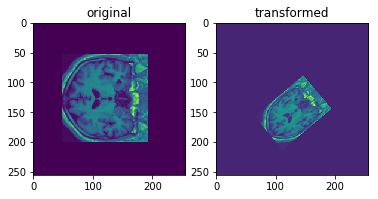

In [13]:
%matplotlib inline
test = my_affine_transform(imgs[0].squeeze(),0.5,0.75,40,tx=5,ty=20,output_grid_shape=(256,256))
f,axarr = plt.subplots(1,2)
axarr[0].set_title('original')
axarr[0].imshow(imgs[0].squeeze())
axarr[1].set_title('transformed')
axarr[1].imshow(test[1])


## Optimization (MS2) change run if you need to actually use it dumbass

In [14]:
run = False
if run:
    %matplotlib inline

    init = np.array([1.5,3,1,2])
    mapping_segmentations = {}

    for i, moving in enumerate(trainings_nonsegs):
        for j, fixed in enumerate(validations_nonsegs):
            modfixed = normalize(fixed)
            modmoving = normalize(moving)
    #         equalfixed  = cv2.equalizeHist(modfixed)
    #         equalmoving = cv2.equalizeHist(modmoving)
    #         clahefixed = clahe.apply(modfixed)
    #         clahemoving = clahe.apply(modmoving)

            optimal_transform, params = optimize(modfixed,modmoving,gamma=10,initial_guess=None)

            # Make gridpoints and interpolate between optimal transform and validation grid
            xx, yy = np.meshgrid(np.arange(fixed.shape[0]),np.arange(fixed.shape[1]),indexing='ij')
            fixedcoords = np.vstack([ xx.reshape(-1), yy.reshape(-1)]).T
            xx, yy = np.meshgrid(np.arange(optimal_transform.shape[0]),np.arange(optimal_transform.shape[1]),indexing='ij')
            optcoords = np.vstack([ xx.reshape(-1), yy.reshape(-1)]).T
            a = griddata(points=optcoords,values=optimal_transform.flatten(),xi=fixedcoords,method='nearest').reshape(fixed.squeeze().shape)

            mapping_segmentations[(i,j)] = [a, params] # store optimal transform in dict
            #  Plot results

            f, axarr = plt.subplots(1,3,figsize=(20,20))

            axarr[0].set_title('Original Training %d' %i)
            axarr[0].imshow(modmoving.squeeze())

            axarr[1].set_title('Validation %d' %j)
            axarr[1].imshow(modfixed.squeeze())

    #         axarr[2].set_title('Optimized Transformed')
    #         axarr[2].imshow(optimal_transform)

            axarr[2].set_title('Interpolated Optimized Transform of Training')
            axarr[2].imshow(a)        
            plt.subplots_adjust(top=0.92, bottom=0.10, left=0.10, right=0.95, hspace=0.55,
                        wspace=0.35)
            plt.show()

        

## Majority Voting Based Label Fusion

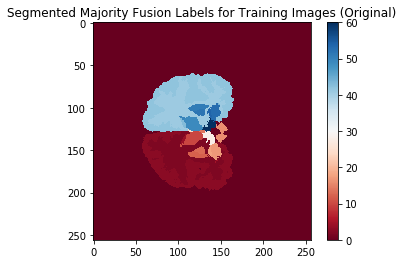

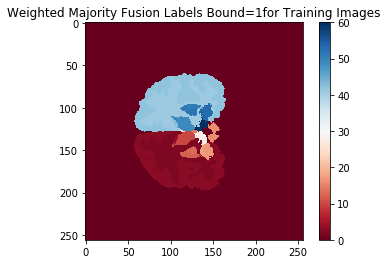

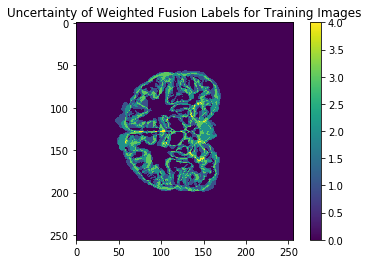

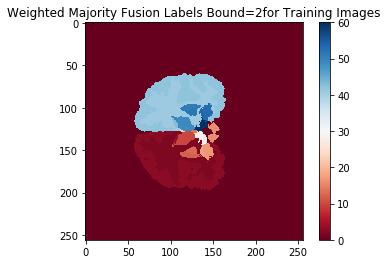

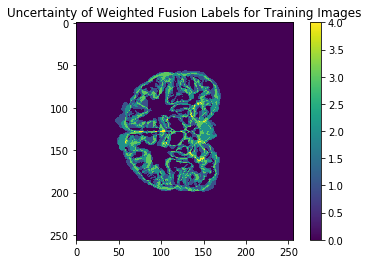

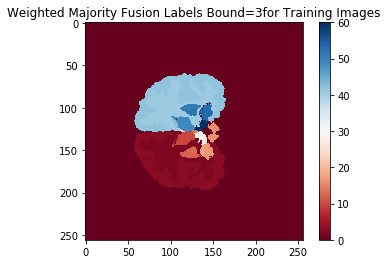

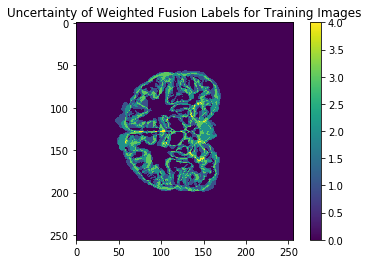

In [15]:
%matplotlib inline
# Majority based labeling 
from scipy.stats import mode
from scipy.signal import convolve2d
# Ties broken by choosing smaller label (default scipy operation)

def majority_fusion(segs_list): 
    votes = mode(np.dstack(segs_list),axis=2)
    return votes[0].squeeze()

def weighted_majority_fusion(segs_list,bound=0):
    if bound > len(segs_list):
        raise ValueError('Bound too big')
    votes,freqs = mode(np.dstack(segs_list),axis=2)
    votes = votes.squeeze()
    freqs = freqs.squeeze()
    votes[np.where(freqs < bound)] = 0 # cancels pixels with lots of uncertainty
    return votes.squeeze(),len(segs_list) - freqs

plt.figure()
training_majority_labs = majority_fusion([trainings_segs[i][0] for i in range(len(trainings_segs))])
plt.imshow(training_majority_labs,cmap='RdBu')
plt.title('Segmented Majority Fusion Labels for Training Images (Original)')
plt.colorbar()

for bound in [1,2,3]:
    weighted_votes, uncertainty = weighted_majority_fusion([trainings_segs[i][0] for i in range(len(trainings_segs))],
                                                           bound=bound)


    plt.figure()
    plt.imshow(weighted_votes,cmap='RdBu')
    plt.title('Weighted Majority Fusion Labels Bound=%dfor Training Images'%bound)
    plt.colorbar()

    plt.figure()
    plt.imshow(uncertainty)
    plt.title('Uncertainty of Weighted Fusion Labels for Training Images')
    plt.colorbar()




def neighbor_filter(x,thresh):
    filt = np.array([[1,1,1],
                     [1,0,1],
                     [1,1,1]])
    
    output = convolve2d(x,filt,mode='same')
    output[np.where(output > thresh)] = 1
    output[np.where(output != 1)] = 0
    return output
# def noise_filter(x,thresh): 
#     x = 1 - neighbor_filter(x)

## Exploring Histogram Equalization

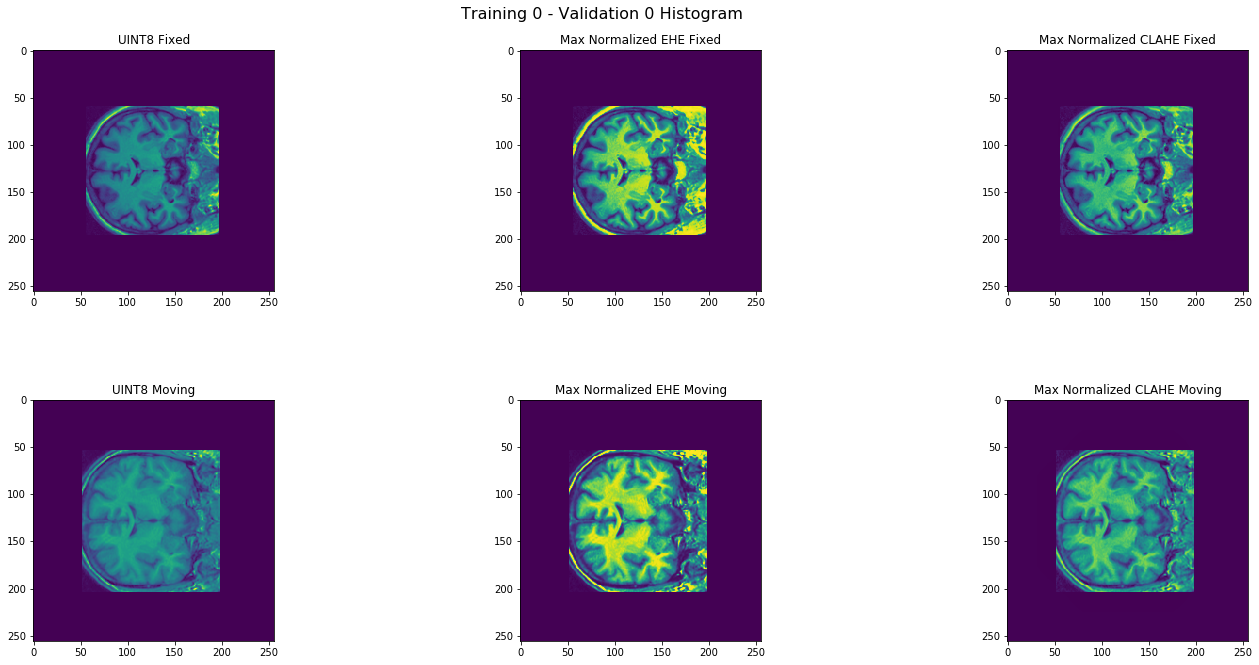

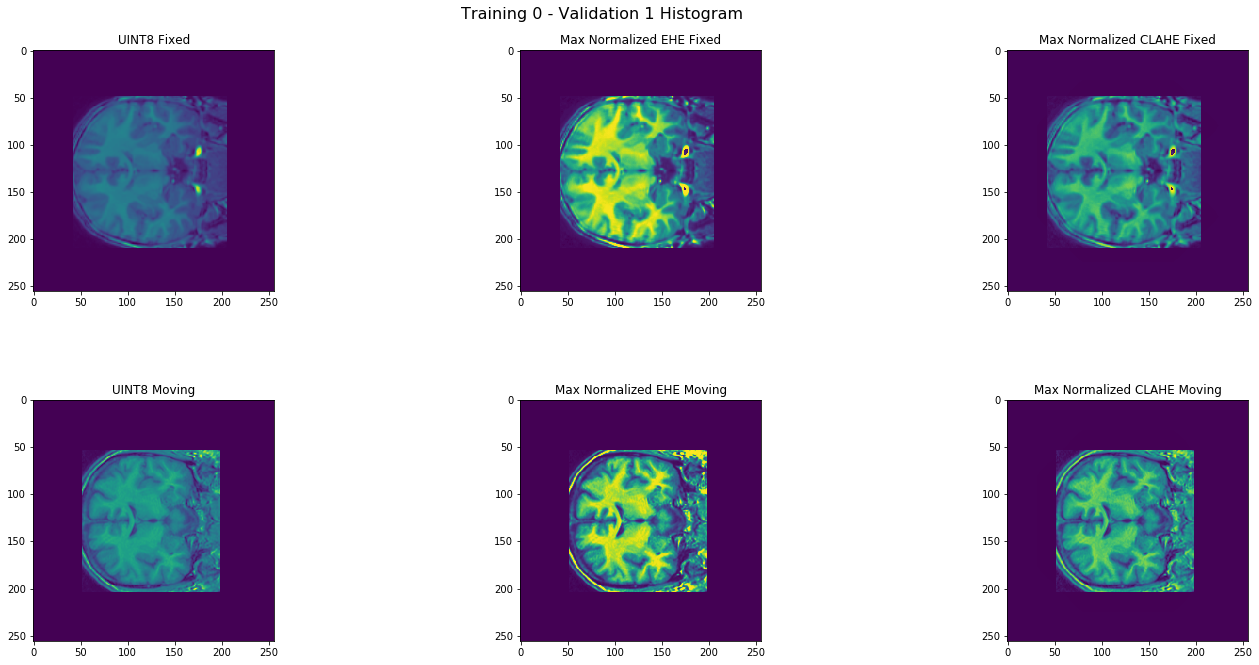

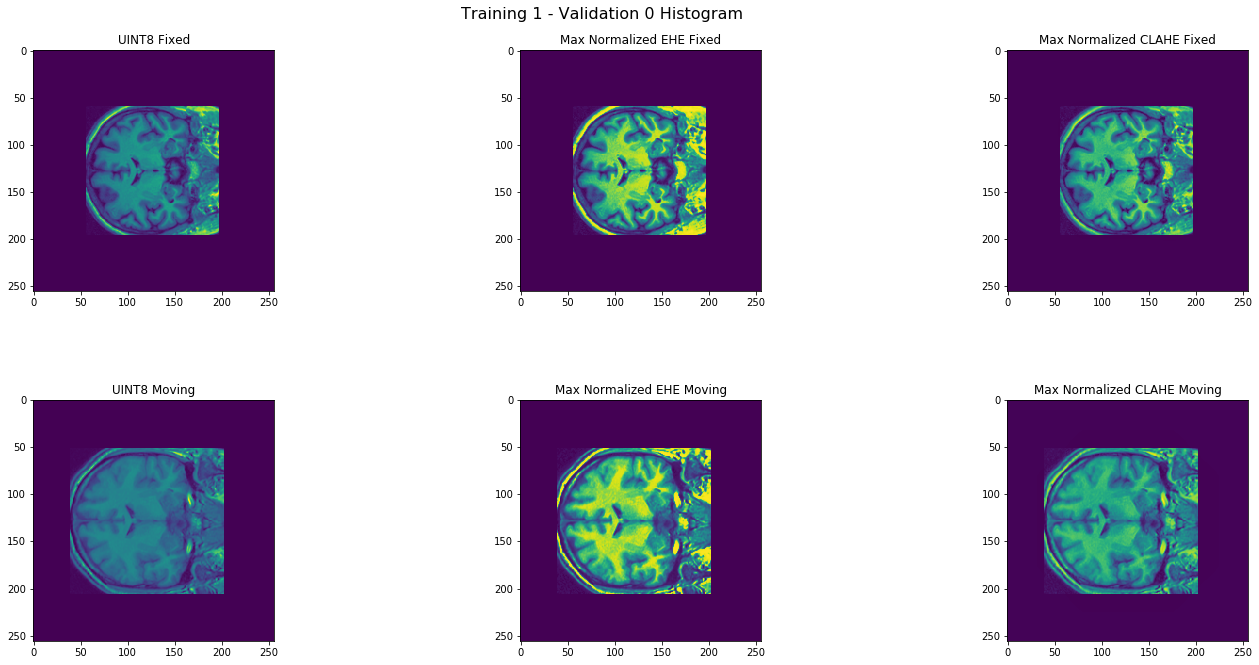

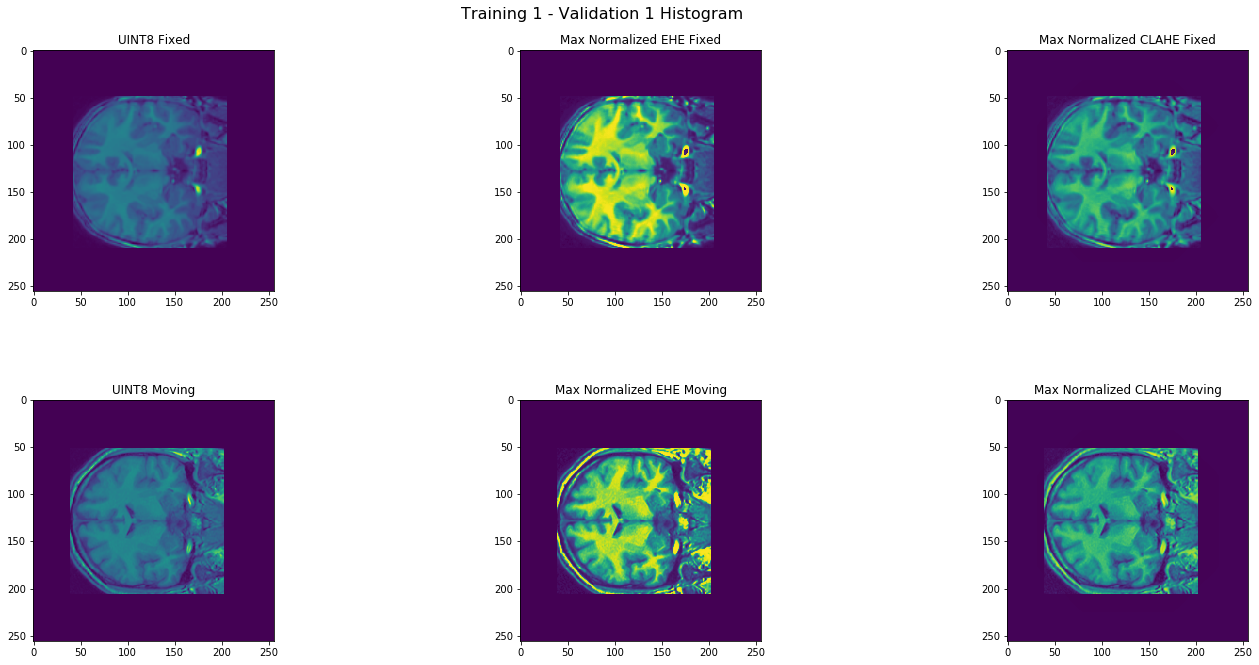

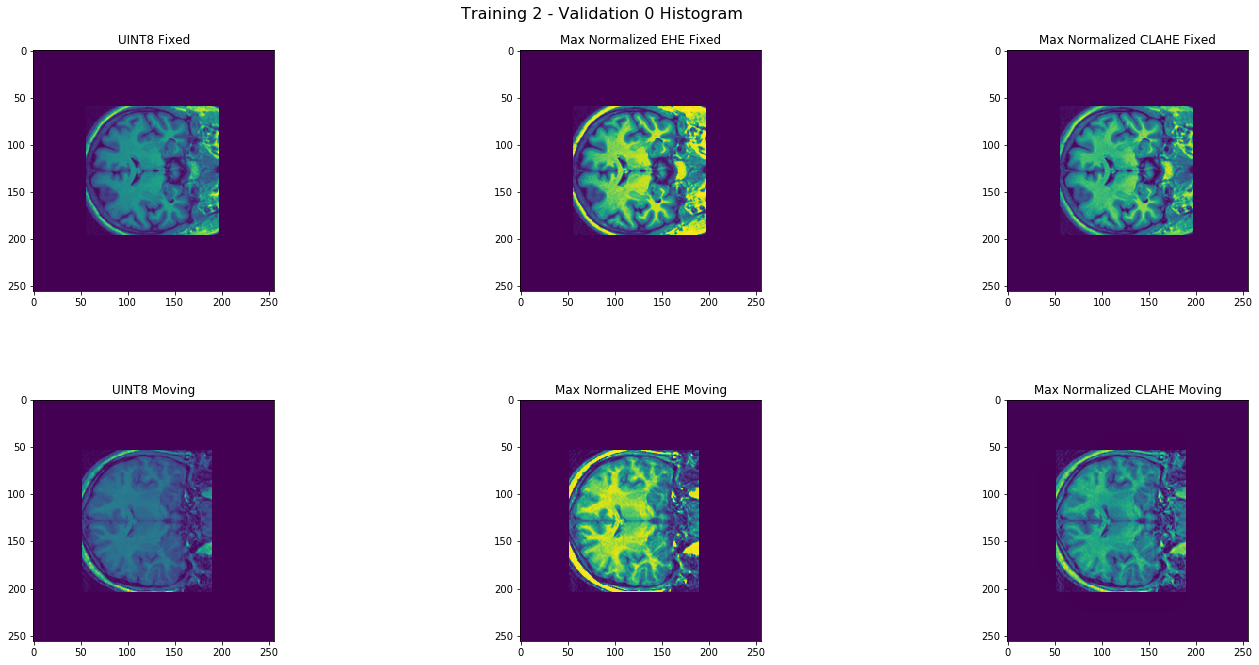

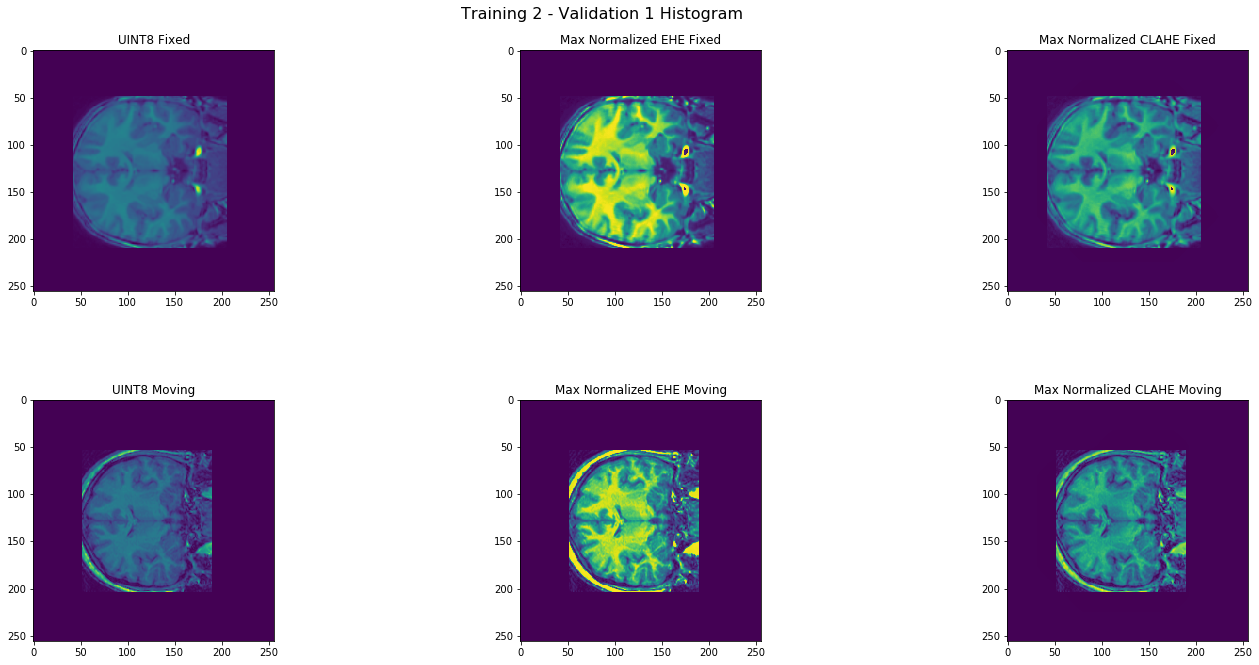

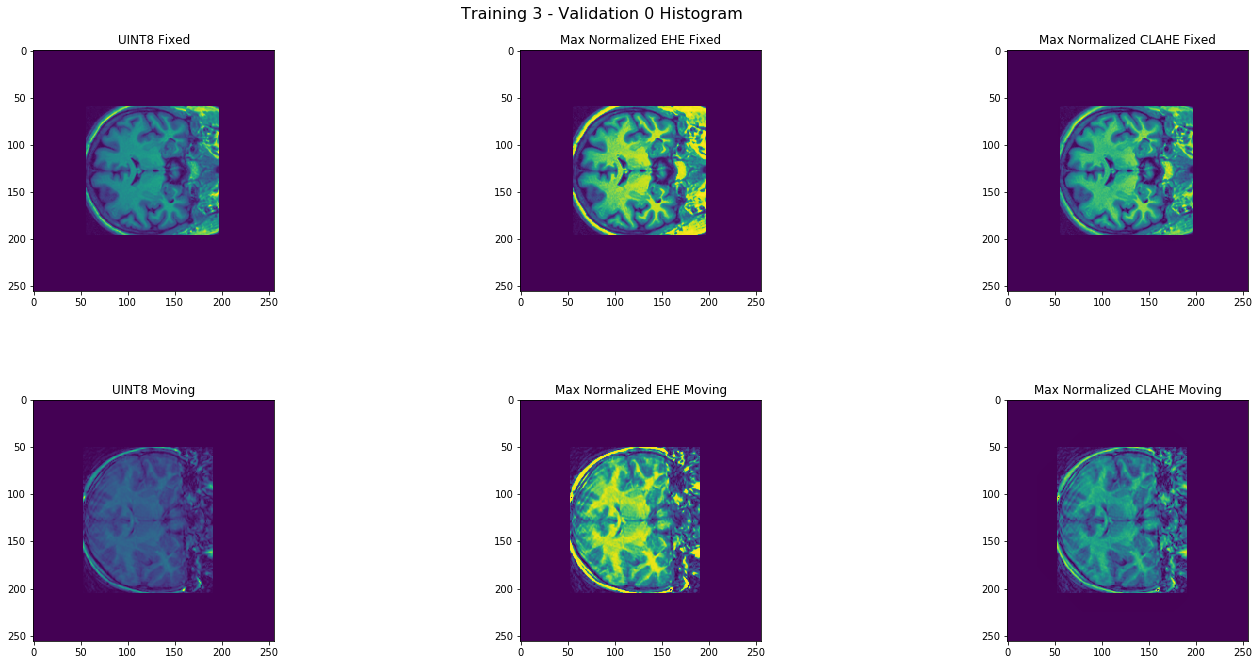

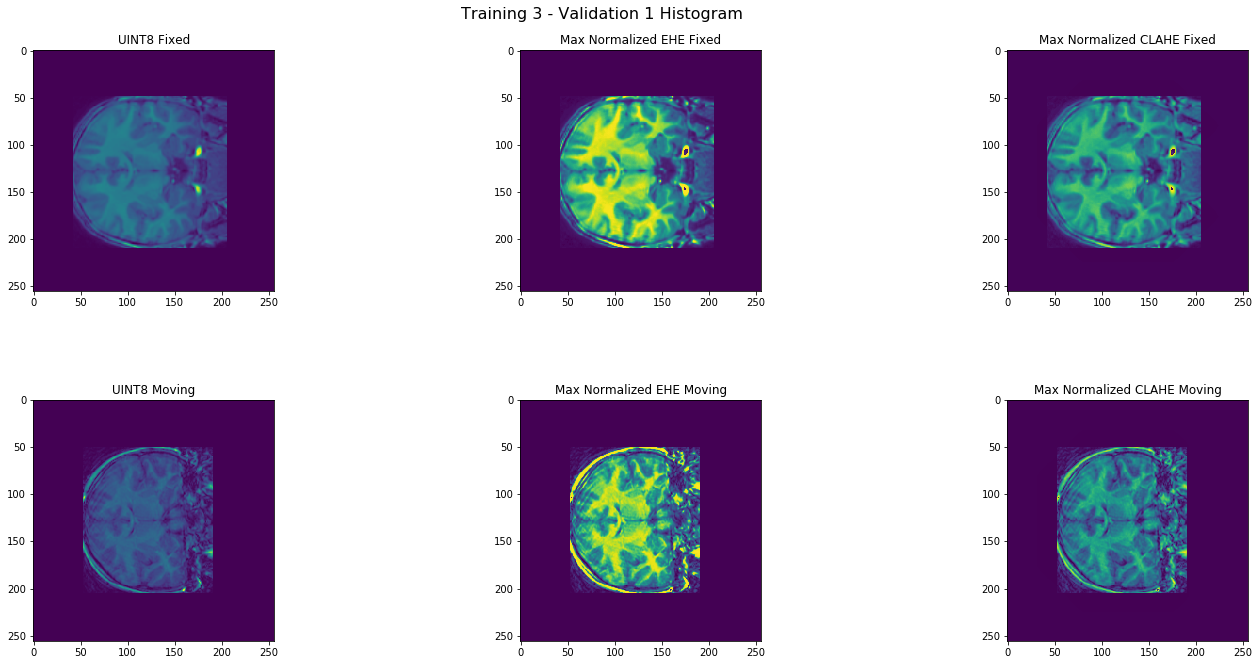

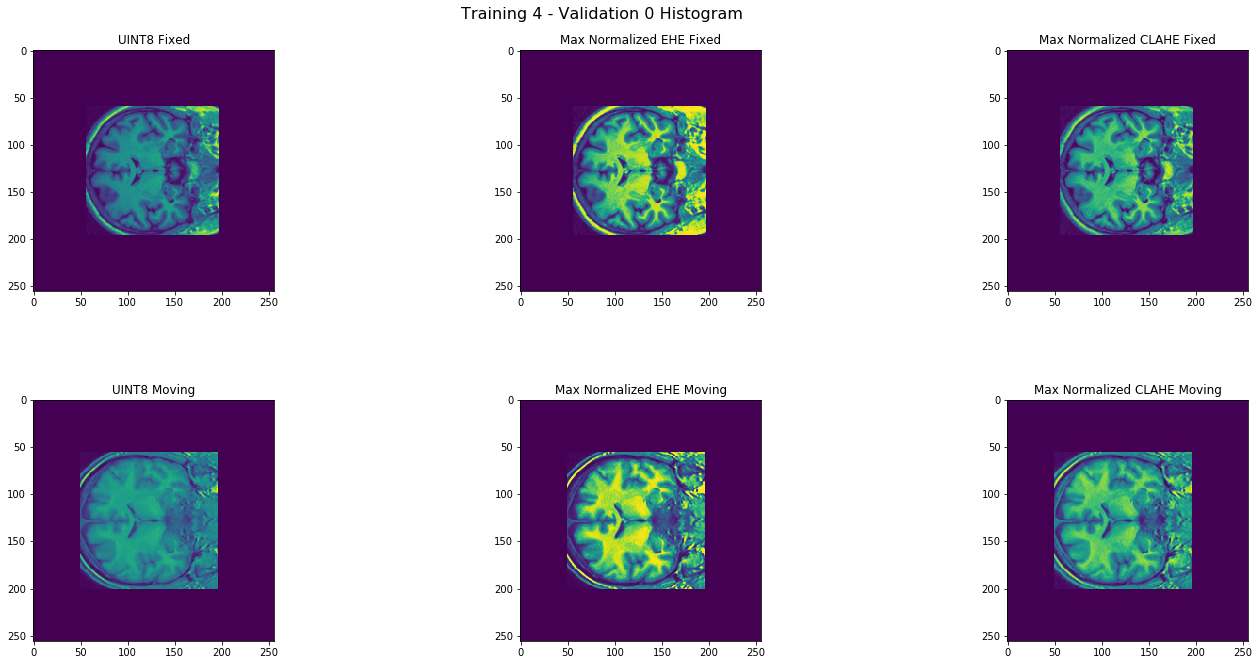

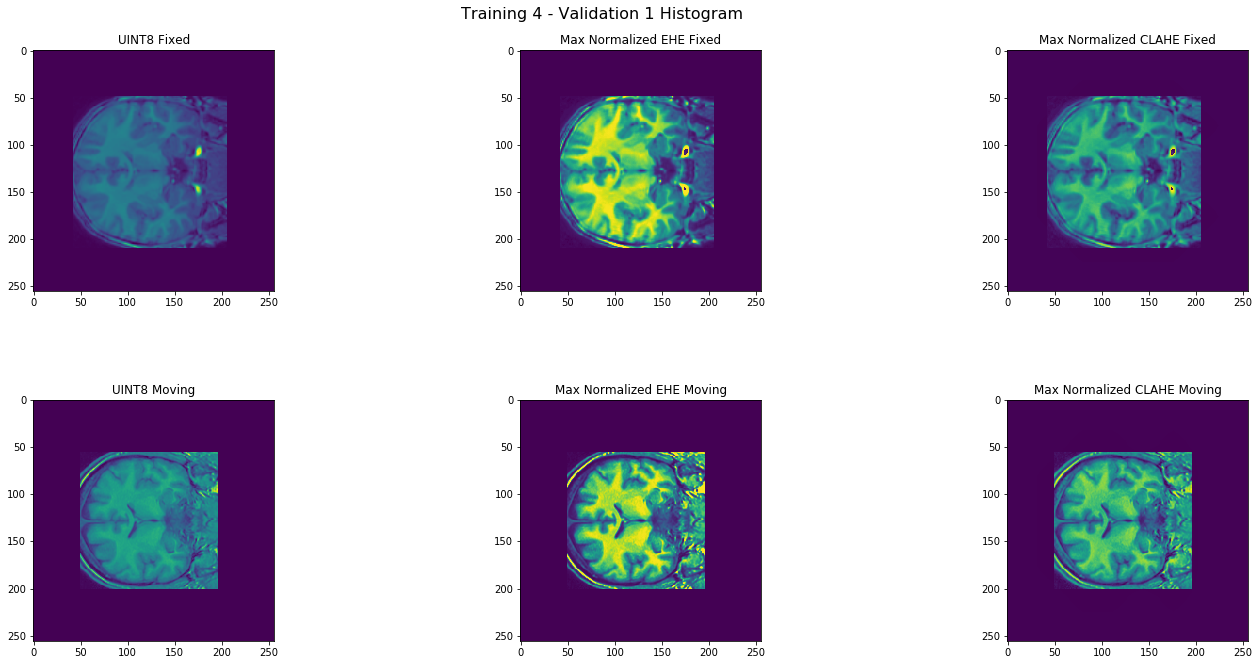

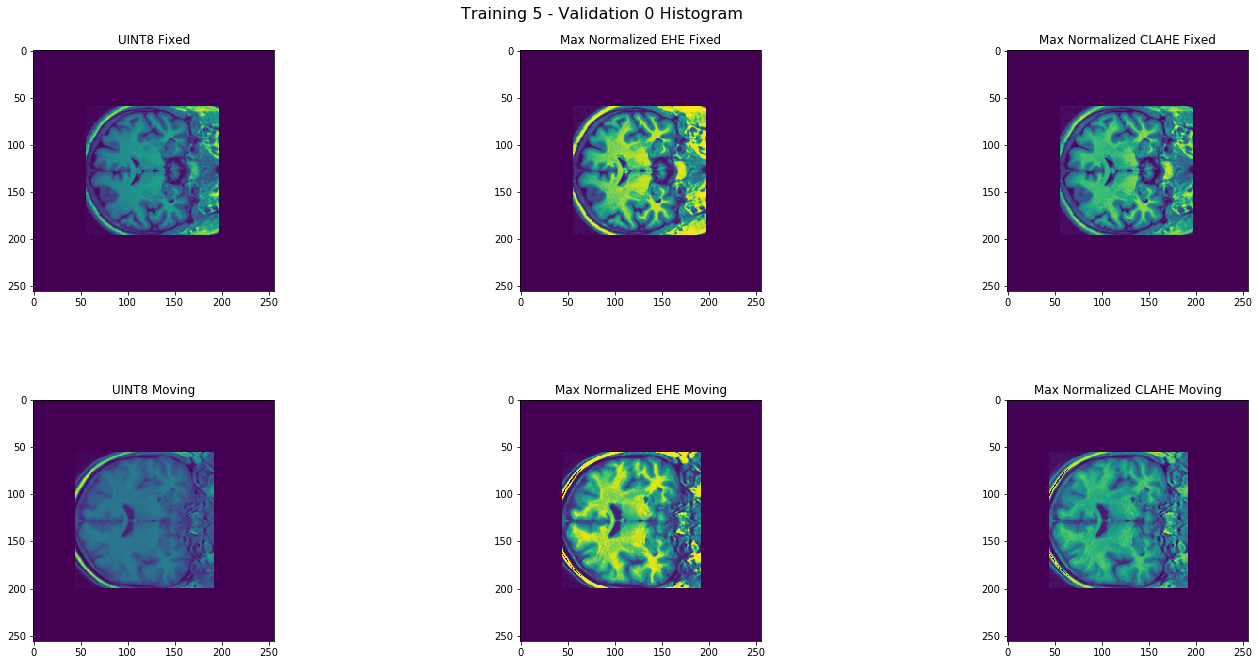

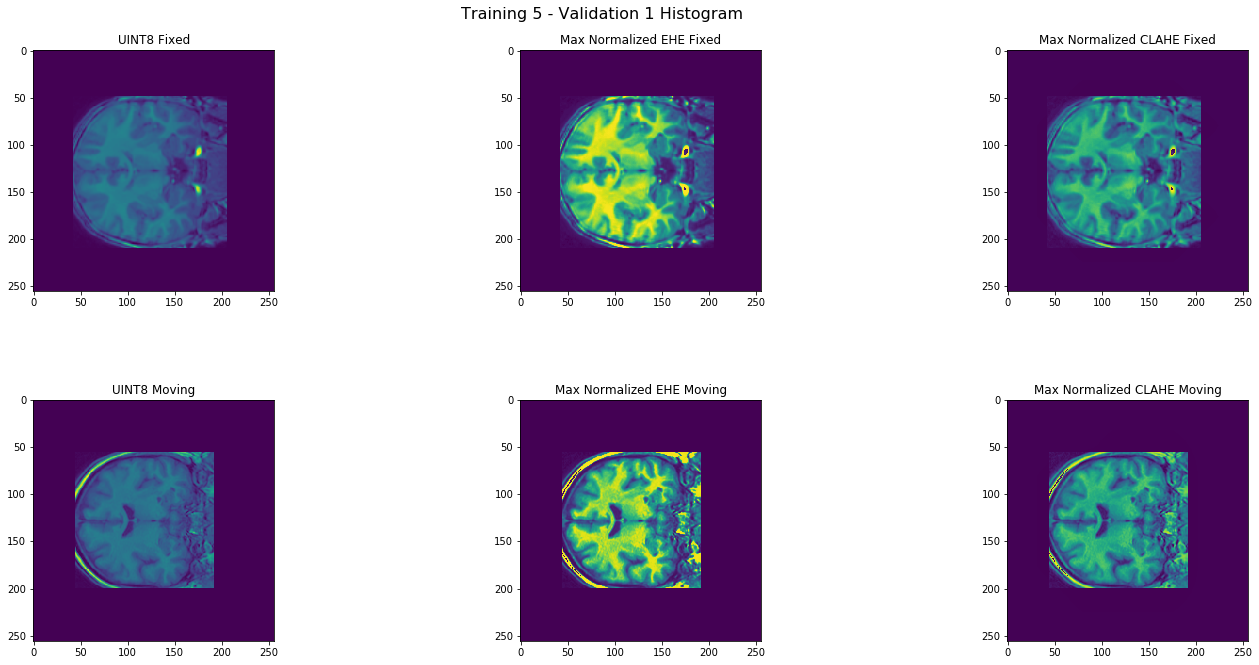

In [16]:
import cv2
for i, moving in enumerate(trainings_nonsegs):
    for j, fixed in enumerate(validations_nonsegs):
        modfixed = (fixed[0].squeeze())
        modmoving = (moving[0].squeeze())
        clahe = cv2.createCLAHE(clipLimit=1.8, tileGridSize=(8,8)) #OG: 2.0, (8,8)
        equalfixed  = normalize(cv2.equalizeHist((modfixed).astype(np.uint8)))
        equalmoving = normalize(cv2.equalizeHist((modmoving).astype(np.uint8)))
        clahefixed = normalize(clahe.apply((modfixed).astype(np.uint8)))
        clahemoving = normalize(clahe.apply((modmoving).astype(np.uint8)))
        f, axarr = plt.subplots(2,3,figsize=(20,10))
        f.suptitle('Training %d - Validation %d Histogram '%(i,j), fontsize=16)
        axarr[0][0].set_title('UINT8 Fixed')
        s = axarr[0][0].imshow(modfixed)  
        axarr[0][1].set_title('Max Normalized EHE Fixed')
        axarr[0][1].imshow(equalfixed)
        axarr[0][2].set_title('Max Normalized CLAHE Fixed')
        axarr[0][2].imshow(clahefixed)  
        axarr[1][0].set_title('UINT8 Moving')
        s = axarr[1][0].imshow(modmoving)  
        axarr[1][1].set_title('Max Normalized EHE Moving')
        axarr[1][1].imshow(equalmoving)
        axarr[1][2].set_title('Max Normalized CLAHE Moving')
        axarr[1][2].imshow(clahemoving)  

        
        
        plt.subplots_adjust(top=0.92, bottom=0.10, left=0.10, right=0.95, hspace=0.45,
                    wspace=0.95)
        plt.plot()
        plt.show()


In [42]:
def alignImages(im1, im2):
  # NOTE: CODE USED FROM LearnOpenCV Tutorial. This was not the original image registration, just an exploration in MS3. 
  # Convert images to grayscale
    im1Gray = cv2.cvtColor(im1.squeeze(), cv2.COLOR_BGR2GRAY)
    im2Gray = cv2.cvtColor(im2.squeeze(), cv2.COLOR_BGR2GRAY)
    MAX_FEATURES = 500
    GOOD_MATCH_PERCENT = 0.15  # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(MAX_FEATURES)
    keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)

    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)

    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)
    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]

    # Draw top matches
    imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Use homography
    height, width, channels = im2.shape
    im1Reg = cv2.warpPerspective(im1, h, (width, height))

    return im1Reg, h
 
def align_register(trainings_nonsegs,validations_nonsegs,gamma=10,histo='clahe',blur=None,ksize=None,view=False):
    mapping_segmentations = {}
    for i, moving in enumerate(trainings_nonsegs):
        for j, fixed in enumerate(validations_nonsegs):
            modfixed = fixed[0].squeeze().astype(np.uint8)
            modmoving = moving[0].squeeze().astype(np.uint8)
            if histo == 'clahe':
                clahe = cv2.createCLAHE(clipLimit=1.8, tileGridSize=(8,8)) #OG: 2.0, (8,8)
                modfixed = clahe.apply(modfixed.astype(np.uint8))
                modmoving = clahe.apply(modmoving.astype(np.uint8))
            elif histo == 'exact':
                modfixed  = cv2.equalizeHist(modfixed.astype(np.uint8))
                modmoving = cv2.equalizeHist(modmoving.astype(np.uint8))
            if blur == 'gaussian':
                modfixed = cv2.GaussianBlur(modfixed,(ksize,ksize), 0, cv2.BORDER_CONSTANT)
                modmoving = cv2.GaussianBlur(modmoving, (ksize,ksize), 0, cv2.BORDER_CONSTANT)
            elif blur == 'average':
                modfixed = cv2.blur(modfixed,(ksize,ksize), cv2.BORDER_CONSTANT)
                modmoving = cv2.blur(modfixed,(ksize,ksize), cv2.BORDER_CONSTANT)
            reg, homography = alignImages(modfixed,modmoving)
            mapping_segmentations[(i,j)] = homography
    return mapping_segmentations


In [17]:
def register(trainings_nonsegs,validations_nonsegs,gamma=10,histo='clahe',blur=None,ksize=None, view=False): 
    mapping_segmentations = {}
    for i, moving in enumerate(trainings_nonsegs):
        for j, fixed in enumerate(validations_nonsegs):
            modfixed = fixed[0].squeeze().astype(np.uint8)
            modmoving = moving[0].squeeze().astype(np.uint8)
            if histo == 'clahe': 
                clahe = cv2.createCLAHE(clipLimit=1.8, tileGridSize=(8,8)) #OG: 2.0, (8,8)
                modfixed = clahe.apply(modfixed.astype(np.uint8))
                modmoving = clahe.apply(modmoving.astype(np.uint8))
            elif histo == 'exact':
                modfixed  = cv2.equalizeHist(modfixed.astype(np.uint8))
                modmoving = cv2.equalizeHist(modmoving.astype(np.uint8))
            if blur == 'gaussian':
                modfixed = cv2.GaussianBlur(modfixed,(ksize,ksize), 0, cv2.BORDER_CONSTANT)
                modmoving = cv2.GaussianBlur(modmoving, (ksize,ksize), 0, cv2.BORDER_CONSTANT)
            elif blur == 'average':
                modfixed = cv2.blur(modfixed,(ksize,ksize), cv2.BORDER_CONSTANT)
                modmoving = cv2.blur(modfixed,(ksize,ksize), cv2.BORDER_CONSTANT)

            optimal_transform, params = optimize(fixed=normalize(modfixed),
                                                 moving=(normalize(modmoving)),
                                                 gamma=gamma,
                                                 initial_guess=None,
                                                 transform_type='affine')
            xx, yy = np.meshgrid(np.arange(fixed[0].shape[0]),np.arange(fixed[0].shape[1]),indexing='ij')
            fixedcoords = np.vstack([ xx.reshape(-1), yy.reshape(-1)]).T
            xx, yy = np.meshgrid(np.arange(optimal_transform.shape[0]),np.arange(optimal_transform.shape[1]),indexing='ij')
            optcoords = np.vstack([ xx.reshape(-1), yy.reshape(-1)]).T
            a = griddata(points=optcoords,
                         values=optimal_transform.flatten(),
                         xi=fixedcoords
                         ,method='nearest').reshape(fixed[0].squeeze().shape)


            mapping_segmentations[(i,j)] = params # store optimal transform in dict
            #  Plot results

            if view: 
                f, axarr = plt.subplots(2,3,figsize=(20,10))
                f.suptitle('CLAHE Adaptive Histogram Transform Applied Before Optimization')
                axarr[0][0].set_title('Original Fixed')
                s = axarr[0][0].imshow(modfixed)  
                axarr[0][1].set_title('CLAHE Transform Fixed')
                axarr[0][1].imshow(clahefixed)
                axarr[0][2].set_title('Optimized')
                axarr[0][2].imshow(optimal_transform)
                axarr[1][0].set_title('Original Moving')
                s = axarr[1][0].imshow(modmoving)  
                axarr[1][1].set_title('CLAHE Histogram Moving')
                axarr[1][1].imshow(clahemoving)
                axarr[1][2].set_title('Interpolated Optimized')
                axarr[1][2].imshow(a)




                plt.subplots_adjust(top=0.92, bottom=0.10, left=0.10, right=0.95, hspace=0.45,
                            wspace=0.95)
                plt.plot()
                plt.show()
    return mapping_segmentations


In [18]:
%matplotlib inline
table = []
label_dict = {2:'Left White Matter', 3:'Left Cerebral Cortex', 41:'Right White Matter',42:'Right Cerebral Cortex'}
def segment(trainings_segs,validations_segs,label_dict,mapping_seg,uncertain=False,view=True):
    table = []
    returned = []
    
    for label in list(label_dict.keys()):
    #         print ('Computing Jaccard Overlap for %s\n======================================\n'%label_dict[label])
        for valid in range(len(validations_segs)):
            manualcopy = np.copy(validations_segs[valid][0].squeeze())
            autocopy = np.zeros_like(manualcopy)
            segment_transforms = []
    #         print (np.unique(manualcopy))
            for mapping, params in mapping_seg.items():  #mapping [0] is training, mapping [1] is valid
#                 print (mapping)
                if mapping[1] == valid: 
    #                 print (validations_segs[valid][1] , ' REGISTERED TO ', trainings_nonsegs[mapping[0]][1])
    #                 print ('TRANSFORMING ', trainings_segs[mapping[0]][1])
    #                 print (np.unique(trainings_segs[mapping[0]][0].squeeze()))
    #                 print (trainings_segs[mapping[0]][0].shape)
    #                     p = np.max(trainings_segs[mapping[0]][0])  # used for reversing effect of normalization
    #                 print ('Max label: ',p)
                    if type(params) == list: 
                        seg_transform =  my_affine_transform((trainings_segs[mapping[0]][0].squeeze().astype(np.uint8)),
                                                                params[0],
                                                                params[1],
                                                                params[2],
                                                                params[3],
                                                                params[4],
                                                                trainings_segs[mapping[0]][0].squeeze().shape)[1]
                    else:
                        seg_transform = cv2.warpPerspective(trainings_segs[mapping[0]][0].squeeze().astype(np.uint8),
                                                            params,
                                                            (autocopy.shape[0], autocopy.shape[1]))
                    segment_transforms.append(seg_transform.astype(np.int16))
    #                 print (np.unique(seg_transform.astype(np.int16)))
            if view: 
                f, axarr = plt.subplots(2,6,figsize=(10,4))
#                 print (len(axarr),len(axarr[0]))
                f.suptitle('Segmentation transforms output for Trainings to Validation %d'%(mapping[1]))
                for i in range(6):
                    for j in range(2):
                        if j == 0:
                            axarr[j][i].imshow(segment_transforms[i])
                        elif j == 1:
                            segcopy = np.zeros_like(segment_transforms[i])
                            segcopy[np.where(segment_transforms[i]==label)] = 1
                            segcopy[np.where(segcopy!=1)] = 0
                            axarr[j][i].imshow(segcopy)
                        else:
                            pass

                plt.subplots_adjust(top=0.92, bottom=0.10, left=0.10, right=0.95, hspace=0.45, wspace=0.95)
                plt.plot()
                plt.show()
            if uncertain: 
                voted, uncertainty = weighted_majority_fusion(segment_transforms,
                                                           bound=2)
            else:
                voted = majority_fusion(segment_transforms)
    #         voted = majority_fusion(segment_transforms)

            autocopy[np.where(voted==label)] = 1
            autocopy[np.where(autocopy != 1)] = 0
            autocopy = neighbor_filter(autocopy,thresh=0)
    #         autocopy = noise_filter (autocopy)
            manualcopy[np.where(manualcopy == label)] = 1
            manualcopy[np.where(manualcopy != 1)] = 0
            assert autocopy.shape == manualcopy.shape and manualcopy.shape == voted.shape
            if view: 
                f, axarr = plt.subplots(1,3,figsize=(20,20))

                axarr[0].set_title('Majority Voted Label ROI %s'%label_dict[label])
                s = axarr[0].imshow(voted)  
                axarr[1].set_title('Manual Segment ROI Val Subject %d: %s'%(valid,label_dict[label]))
                axarr[1].imshow(manualcopy)
                axarr[2].set_title('Automated Segment ROI %s'%label_dict[label])
                axarr[2].imshow(autocopy)  
                plt.subplots_adjust(top=0.92, bottom=0.10, left=0.10, right=0.95, hspace=0.45, wspace=0.95)
                plt.plot()
                plt.show()
            jac = jaccard(manualcopy,autocopy)
            returned.append(autocopy)
#             print ('Jaccard Overlap: ', jac)
            manualcopy = np.zeros_like(autocopy)
            table.append([valid,label_dict[label],jac]) #  validation subjects x labels
    return table, returned 

C:\Users\shubh\Anaconda3\envs\python36\lib\site-packages\scipy\ndimage\interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Optimization terminated successfully.
         Current function value: 653.251415
         Iterations: 6
         Function evaluations: 735
[ 0.90039063  0.93164063 -0.56484424  1.32170289 -0.45342927]


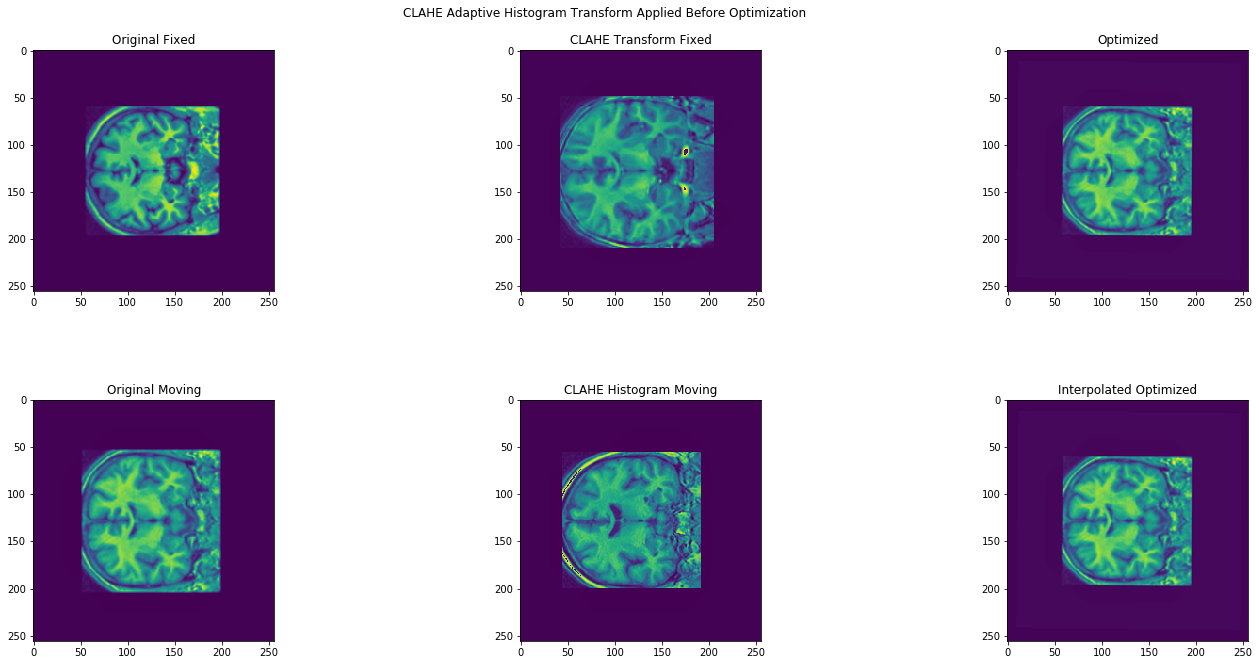

Optimization terminated successfully.
         Current function value: 955.330716
         Iterations: 6
         Function evaluations: 677
[ 1.04492188  1.05273438 -1.61433539 -2.35486305 -0.10747684]


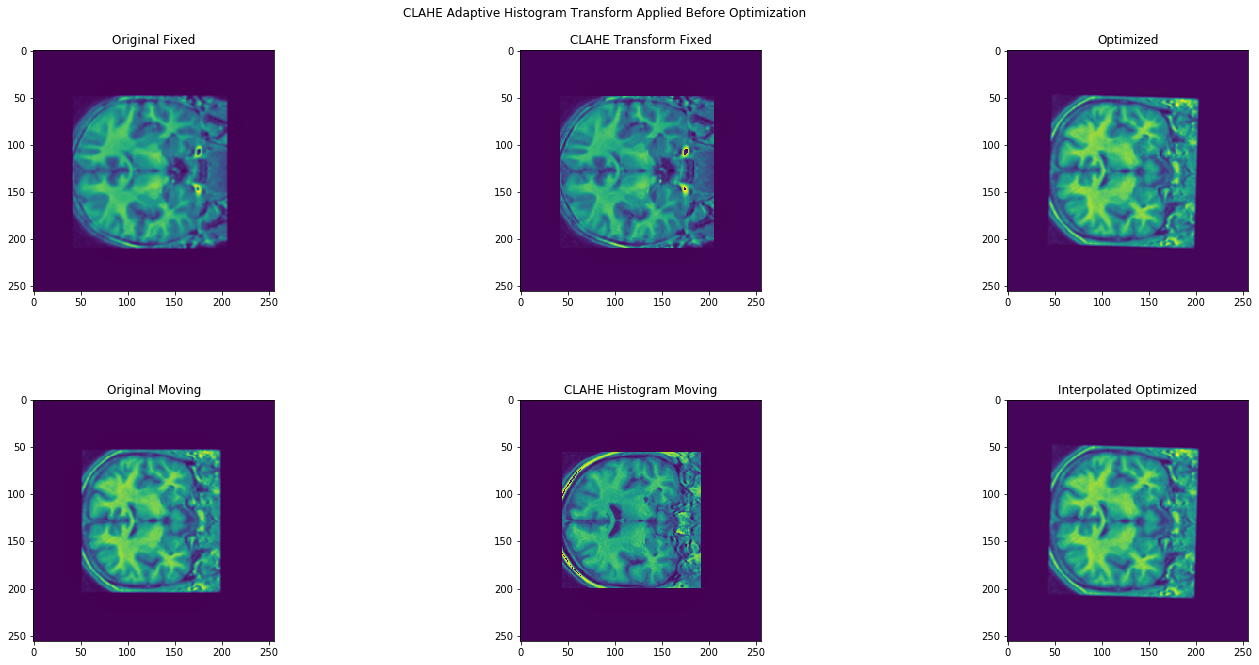

Optimization terminated successfully.
         Current function value: 704.895760
         Iterations: 8
         Function evaluations: 987
[ 0.88476563  0.86914063  0.1263391   3.56300872 -0.51076026]


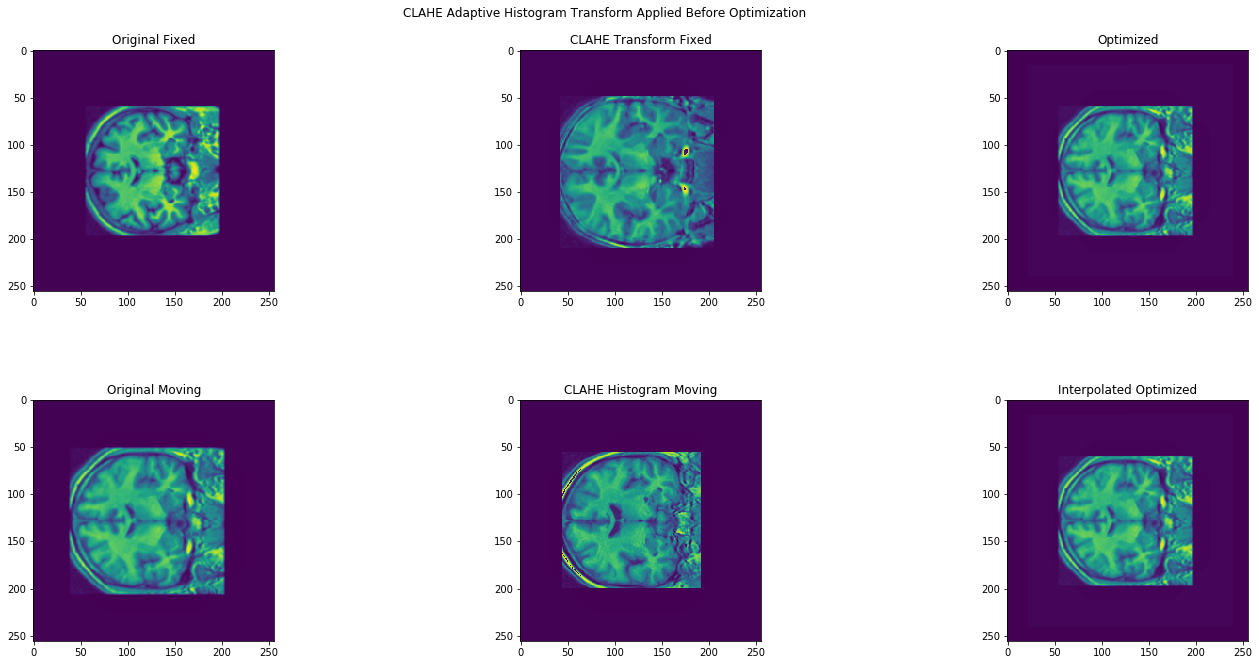

Optimization terminated successfully.
         Current function value: 1001.679388
         Iterations: 6
         Function evaluations: 718
[ 1.03320313  0.95117188 -0.59036049 -1.53027205  0.15212678]


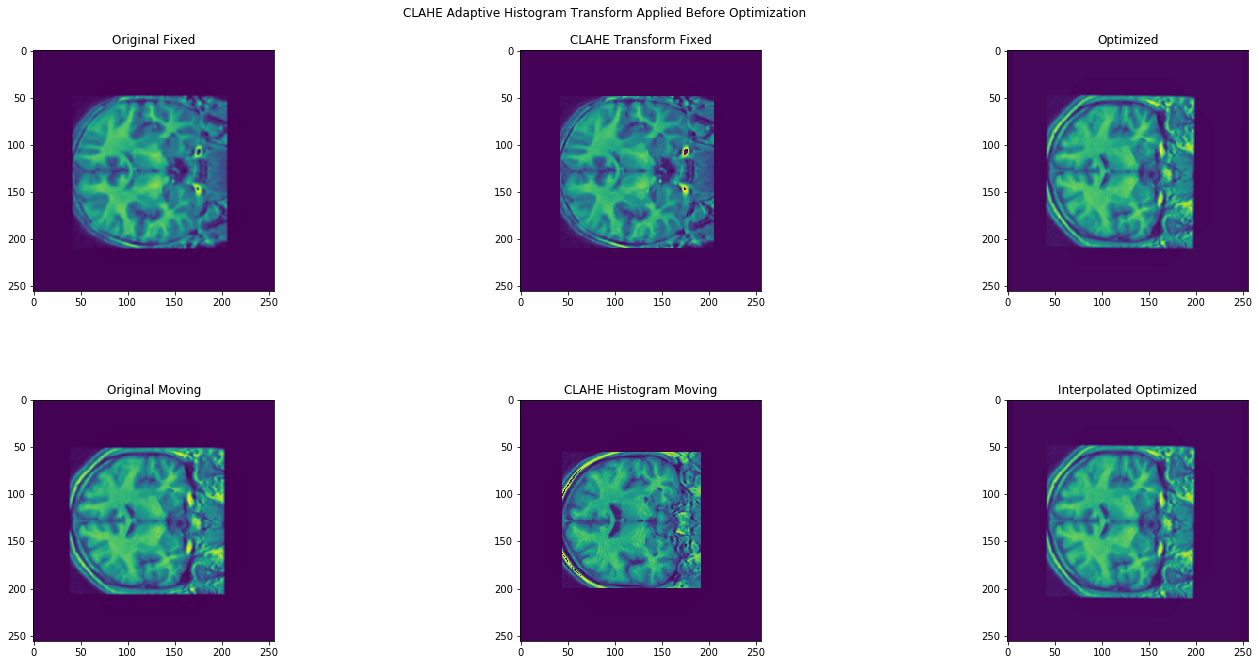

Optimization terminated successfully.
         Current function value: 1089.614786
         Iterations: 10
         Function evaluations: 1101
[ 0.92391237  1.01757813 -1.09958137  5.4932104   0.3306769 ]


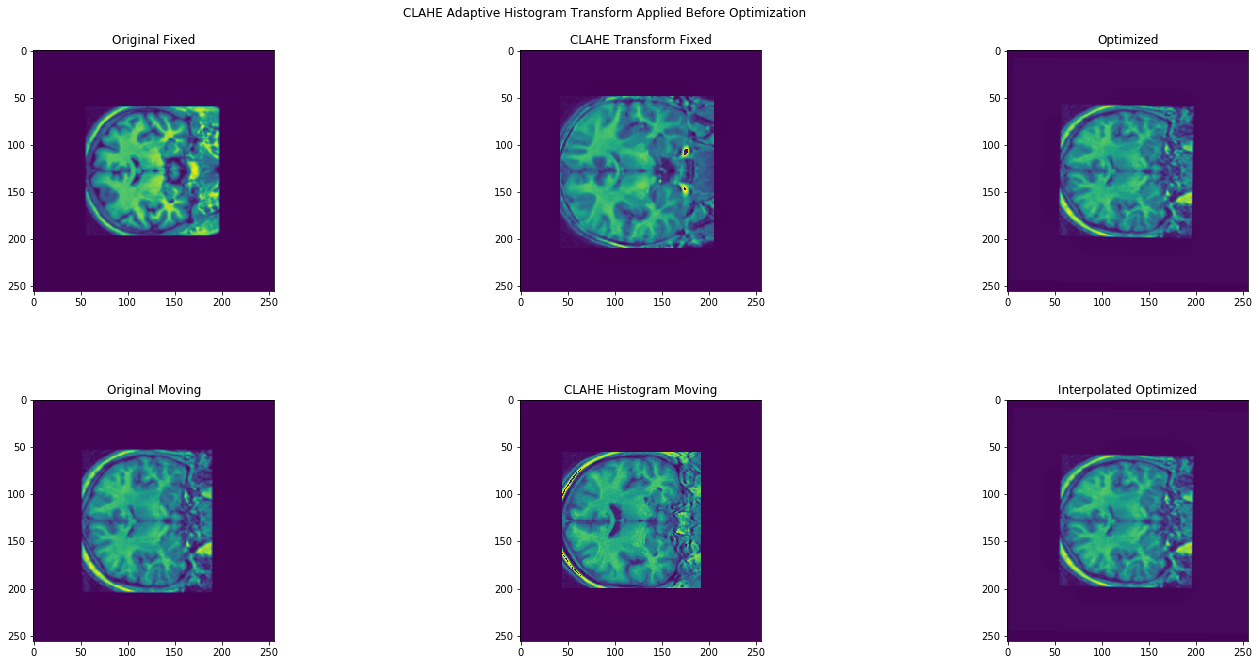

Optimization terminated successfully.
         Current function value: 978.914818
         Iterations: 5
         Function evaluations: 503
[ 1.06835938  1.13085938 -1.86786618  1.55847677  0.26483966]


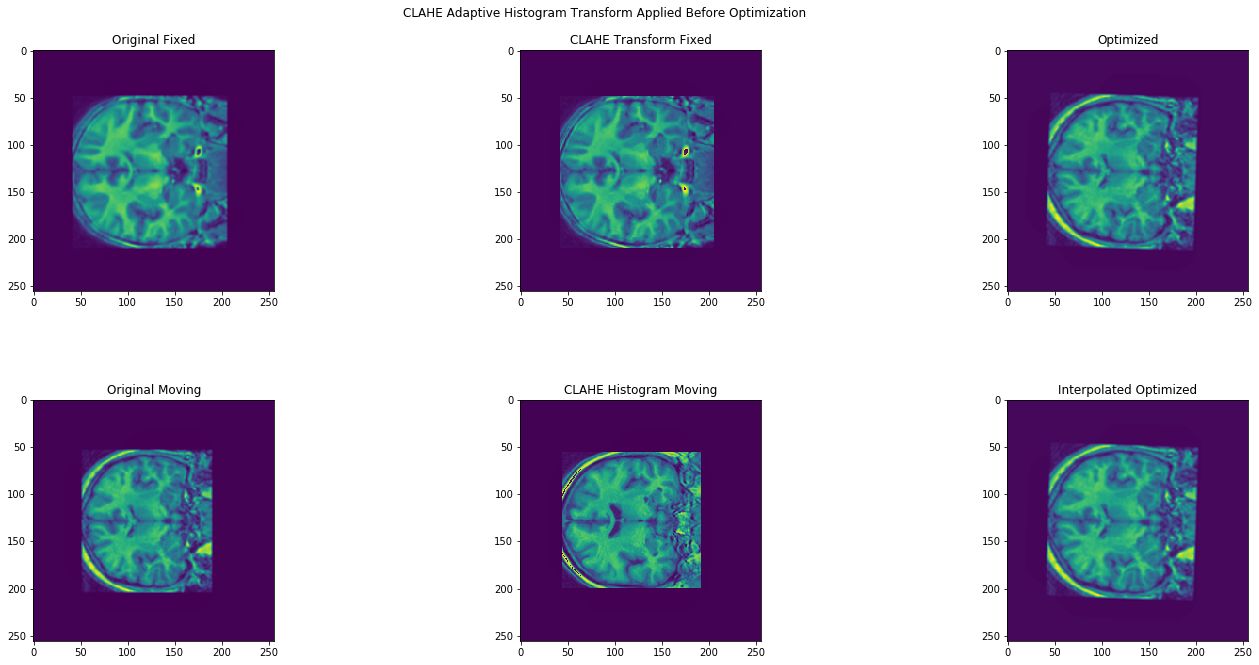

Optimization terminated successfully.
         Current function value: 1116.621821
         Iterations: 9
         Function evaluations: 1160
[ 0.91210938  1.02929688 -0.76414228  3.68047161 -0.3853897 ]


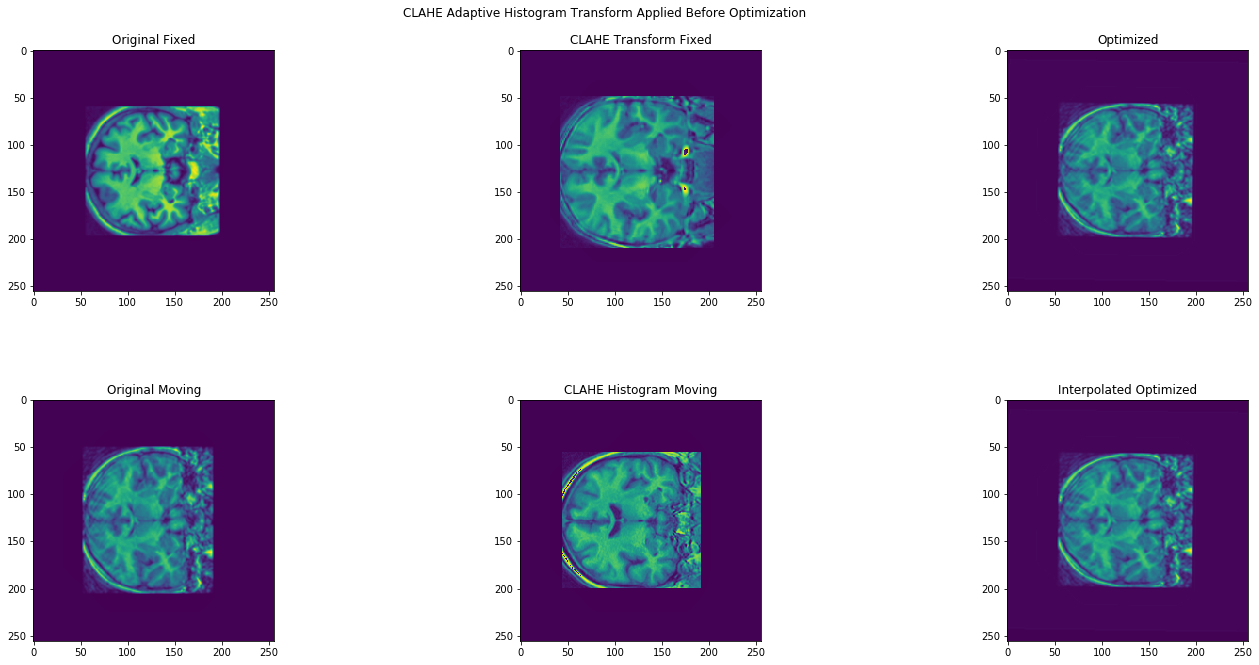

Optimization terminated successfully.
         Current function value: 792.498540
         Iterations: 8
         Function evaluations: 941
[ 1.04492188  1.18164063 -2.21293649  1.50106289  0.67350699]


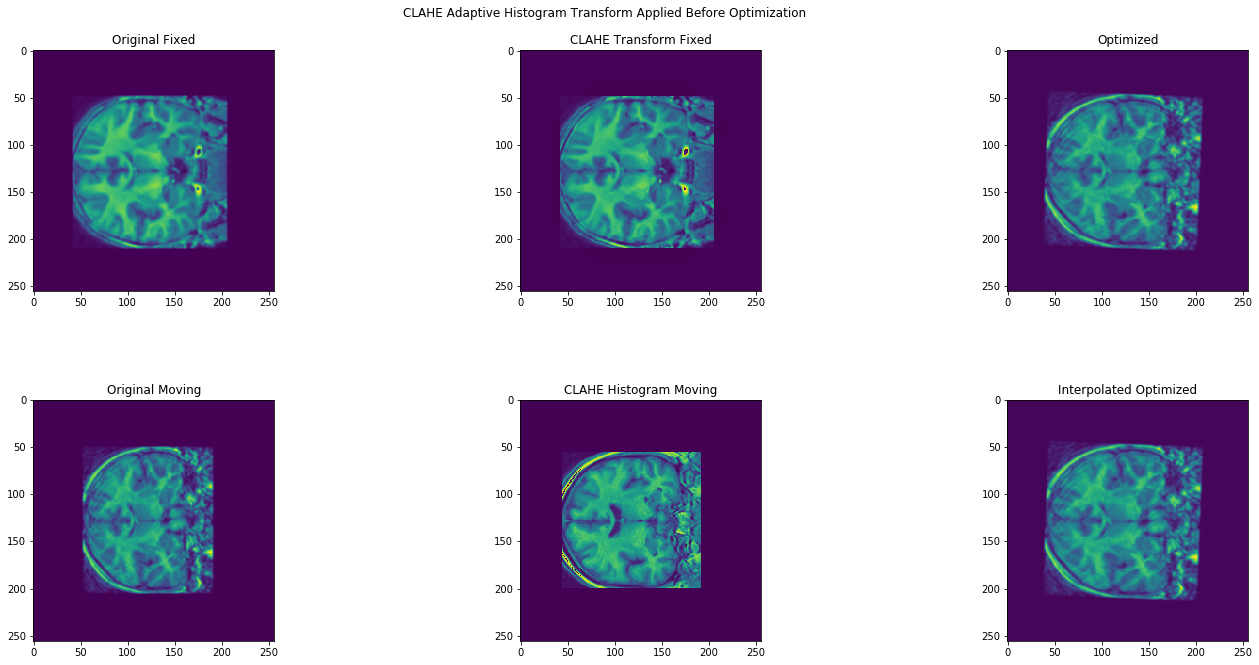

Optimization terminated successfully.
         Current function value: 842.762041
         Iterations: 7
         Function evaluations: 762
[ 0.92773438  0.95117188 -0.75815683  3.40532976 -0.40634022]


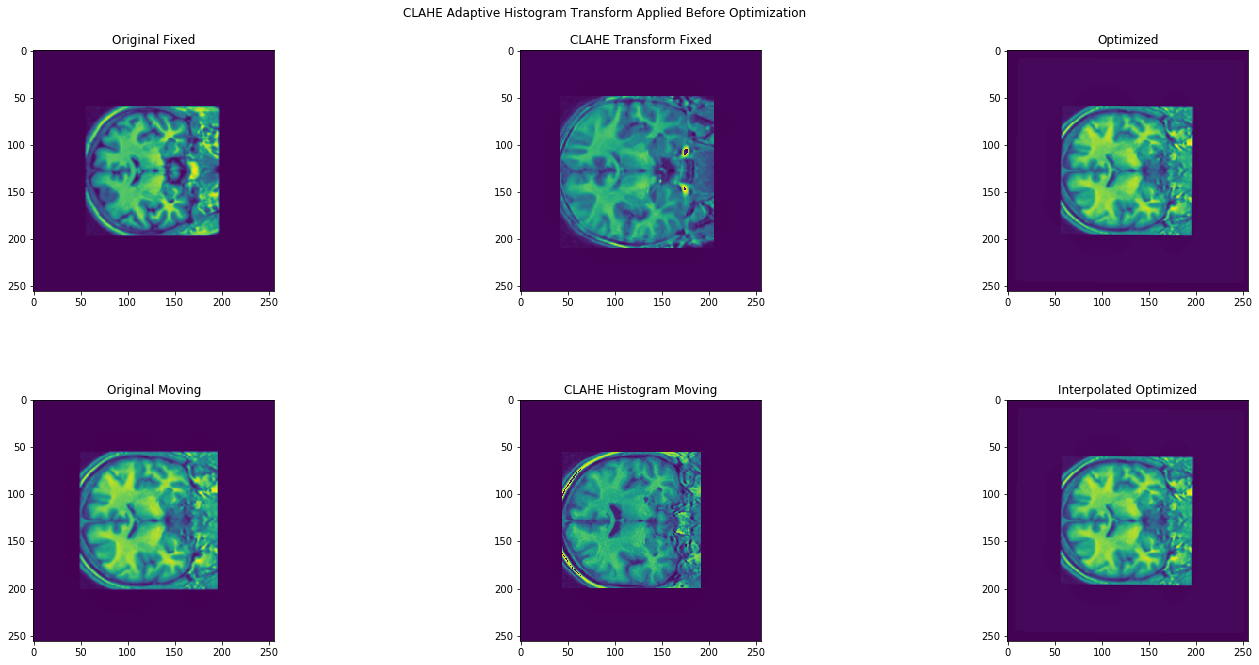

Optimization terminated successfully.
         Current function value: 1160.590776
         Iterations: 8
         Function evaluations: 1018
[ 1.08398438  1.02539063 -1.21183699 -1.31400029  0.13163673]


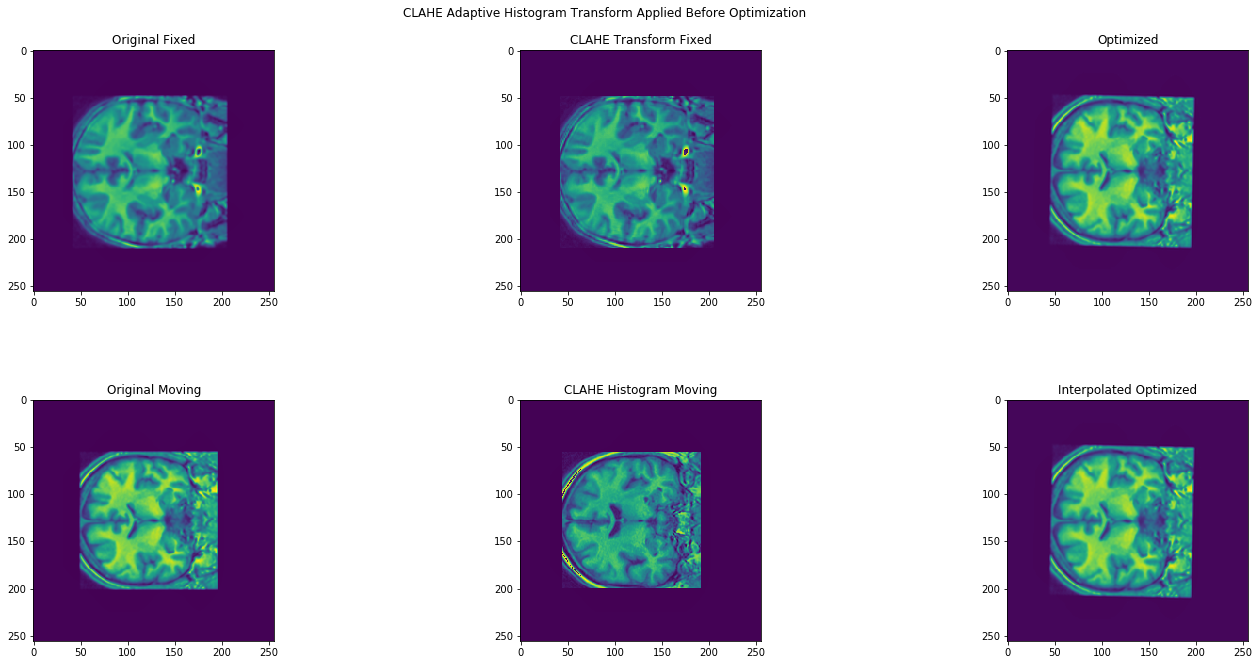

Optimization terminated successfully.
         Current function value: 926.989250
         Iterations: 8
         Function evaluations: 1070
[ 0.92382813  0.91992188 -0.61022164  4.7918032  -1.0709645 ]


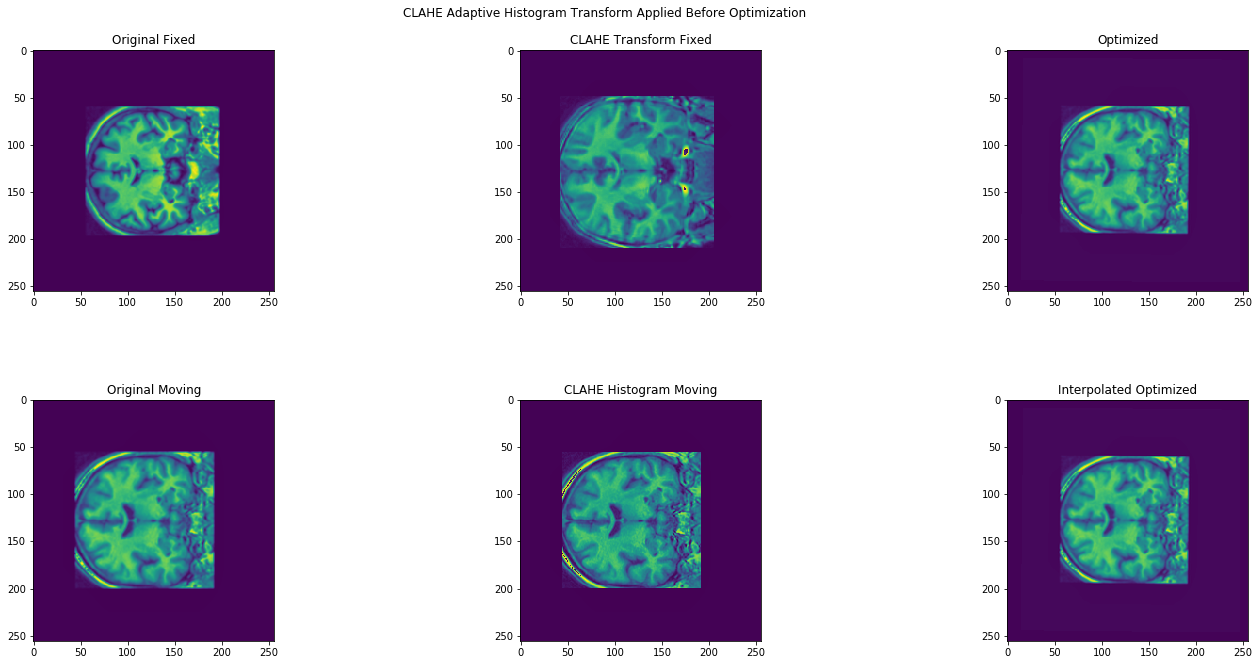

Optimization terminated successfully.
         Current function value: 1027.960467
         Iterations: 6
         Function evaluations: 755
[ 1.08789063  1.02929688 -0.72310102 -0.14820457  0.47242631]


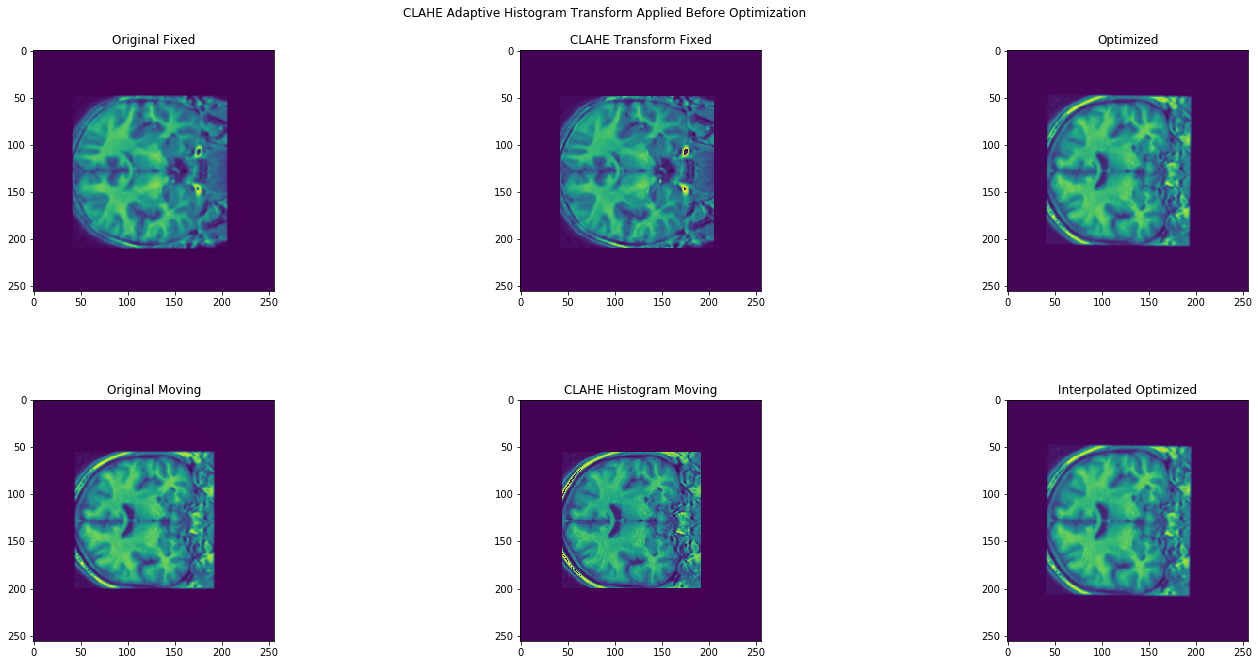

In [19]:
import pandas as pd
''' 
MS 3 RESULTS:
   Val                    ROI  Jaccard Overlap
0    0      Left White Matter         0.594867
1    1      Left White Matter         0.508571
2    0   Left Cerebral Cortex         0.615570
3    1   Left Cerebral Cortex         0.426893
4    0     Right White Matter         0.553585
5    1     Right White Matter         0.539449
6    0  Right Cerebral Cortex         0.532228
7    1  Right Cerebral Cortex         0.420507


'''
mappings_segmentations = register(trainings_nonsegs,validations_nonsegs,histo="clahe",blur='gaussian', ksize=3, gamma=10,view=True)

In [20]:
table, returned = segment(trainings_segs,validations_segs,label_dict,mappings_segmentations,uncertain=True,view=False)
print (pd.DataFrame(table,columns=['Val','ROI','Jaccard Overlap']))

   Val                    ROI  Jaccard Overlap
0    0      Left White Matter         0.566406
1    1      Left White Matter         0.563810
2    0   Left Cerebral Cortex         0.601019
3    1   Left Cerebral Cortex         0.438825
4    0     Right White Matter         0.524249
5    1     Right White Matter         0.542115
6    0  Right Cerebral Cortex         0.577542
7    1  Right Cerebral Cortex         0.459408


In [27]:
def segment_infer (trainings_segs,testid,label,mappings_segmentations,uncertain=False,neighbor_thresh=0):
    segment_transforms = []
    
    #         print (np.unique(manualcopy))
    for mapping, params in mappings_segmentations.items():  #mapping [0] is training, mapping [1] is valid
        if mapping[1] == testid:
#             print (trainings_segs)
            seg_transform =  my_affine_transform((trainings_segs[mapping[0]][0].squeeze().astype(np.uint8)),
                                                    params[0],
                                                    params[1],
                                                    params[2],
                                                    params[3],
                                                    params[4],
                                                    trainings_segs[mapping[0]][0].squeeze().shape)[1]
            segment_transforms.append(seg_transform.astype(np.int16))
    if uncertain: 
        voted, uncertainty = weighted_majority_fusion(segment_transforms,
                                                       bound=2)
    else:
        voted = majority_fusion(segment_transforms)
    autocopy = np.zeros_like(voted)
    #         voted = majority_fusion(segment_transforms)
    autocopy[np.where(voted==label)] = 1
    autocopy[np.where(autocopy != 1)] = 0
    autocopy = neighbor_filter(autocopy,thresh=neighbor_thresh)
    return autocopy

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [25]:
test_maps = register(trainings_nonsegs ,testings_nonsegs,histo='clahe',gamma=10,blur='gaussian',ksize=5,view=False) # can maybe include validations among trainings

C:\Users\shubh\Anaconda3\envs\python36\lib\site-packages\scipy\ndimage\interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Optimization terminated successfully.
         Current function value: 1087.343356
         Iterations: 6
         Function evaluations: 742
[ 0.95117188  0.91210938  0.12256367 -2.29136887 -1.65393096]
Optimization terminated successfully.
         Current function value: 805.862279
         Iterations: 6
         Function evaluations: 728
[ 0.90429688  0.99414063 -0.33794269 -1.06213502 -0.98472349]
Optimization terminated successfully.
         Current function value: 926.521389
         Iterations: 6
         Function evaluations: 777
[ 0.91992188  1.00976563 -0.61052816  0.27317513 -1.77379519]
Optimization terminated successfully.
         Current function value: 1453.366047
         Iterations: 7
         Function evaluations: 828
[ 0.93945313  1.02148438 -0.8388012  -7.34344098 -2.7224547 ]
Optimization terminated successfully.
         Current function value: 982.956455
         Iterations: 7
         Function evaluations: 1096
[ 0.99414063  0.88867188 -1.47768092 -3.56572262 

Optimization terminated successfully.
         Current function value: 685.451468
         Iterations: 7
         Function evaluations: 857
[ 0.96679688  1.01367188 -1.18157002 -0.71658588 -0.7943292 ]
Optimization terminated successfully.
         Current function value: 686.565202
         Iterations: 8
         Function evaluations: 1038
[ 0.97070313  1.08406442 -1.56508897 -2.68457879 -0.17463595]
Optimization terminated successfully.
         Current function value: 678.133201
         Iterations: 6
         Function evaluations: 843
[ 1.08789063  1.20898438 -1.56412369 -2.85521388 -0.25093159]
Optimization terminated successfully.
         Current function value: 861.737441
         Iterations: 6
         Function evaluations: 646
[ 1.11523438  1.22851563 -1.1936692  -2.0945193  -0.41189571]
Optimization terminated successfully.
         Current function value: 1232.162974
         Iterations: 7
         Function evaluations: 752
[ 0.99024436  0.89257813 -0.42881047  0.3642122  -

In [28]:
label_dict = {2:'-left-wm', 3:'-left-cortex', 41:'-right-wm',42:'-right-cortex'}
actual_isbrs = [8,9,10,11,12,13,14,16,17]
submitted = {}
ids = []
encodes = []
for testnum, test_img in enumerate(testings_nonsegs): 
    for label in list(label_dict.keys()):
        auto = segment_infer(trainings_segs + validations_segs ,
                             testid=testnum,
                             label=label,
                             mappings_segmentations=test_maps,
                             uncertain=True,
                             neighbor_thresh=2
                            )
        myid = str(actual_isbrs[testnum]) + label_dict[label]
        ids.append(myid)
        encoded_auto = rle_encode(auto)
        encodes.append(encoded_auto)
submitted = pd.DataFrame({"Id": ids, "Predicted": encodes})
submitted.to_csv('submitted3.csv',index=False)

# submitted = 0.66404 DICE
# uncertain_false = 0.66174 DICE
# submitted3 = DICE with 5x5 Gaussian

In [43]:
test_maps = align_register(trainings_nonsegs,validations_nonsegs,gamma=10,histo='clahe',blur=None,ksize=None,view=True)
table, binaries = segment(trainings_segs,validations_segs,label_dict,test_maps,uncertain=False,view=True)
print (pd.DataFrame(table,columns=['Val','ROI','Jac']))

NameError: name 'im1Gray' is not defined